In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import cartopy

Caricamento dei file pickle

In [2]:
# Caricamento di models e models_atmos
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
#Caricamento dei file pickle di modelli_tos
with open('modelli_tos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0_pca = pickle.load(f)
    list_cluster1_pca = pickle.load(f)
    list_cluster2_pca = pickle.load(f)
    list_cluster3_pca = pickle.load(f)
    list_cluster4_pca = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    cluster_0_pdf = pickle.load(f)
    cluster_1_pdf = pickle.load(f)
    cluster_2_pdf = pickle.load(f)
    cluster_3_pdf = pickle.load(f)
    cluster_4_pdf = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    cluster_0_mean_pdf = pickle.load(f)
    cluster_1_mean_pdf = pickle.load(f)
    cluster_2_mean_pdf = pickle.load(f)
    cluster_3_mean_pdf = pickle.load(f)
    cluster_4_mean_pdf = pickle.load(f)

In [3]:
list_cluster0 = list_cluster0_pca
list_cluster1 = list_cluster1_pca
list_cluster2 = list_cluster2_pca
list_cluster3 = list_cluster3_pca
list_cluster4 = list_cluster4_pca

In [4]:
#Bias modelli
for name in models:
    #Seleziono il box Nord Atlantico
    na_box = models[name]['North Atlantic box']
    #dataset nel box gulf stream
    models[name]['GS box'] = models[name]['North Atlantic box'].sel(time=slice("1982-01","2014-12"),lon=slice(282,310),lat=slice(29,50))
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli, per un anno --> da aggiungere anni!
        model_na_seas_mean = compute_mean_resample_mar(na_box["tos"],"1982","2014",i)
        if (i+1) == 4 : #DJF
            models[name]['tos North Atlantic seasonal mean DJF'] = model_na_seas_mean
    #seleziono un sottobox in cui vado a cercare la corrente del Golfo --> seas mean DJF nel GS box
    models[name]['GS box seas mean DJF'] = models[name]['tos North Atlantic seasonal mean DJF'].sel(lon=slice(282,310), lat=slice(29,50)) #box Gulf Stream

Posizione della corrente del Golfo

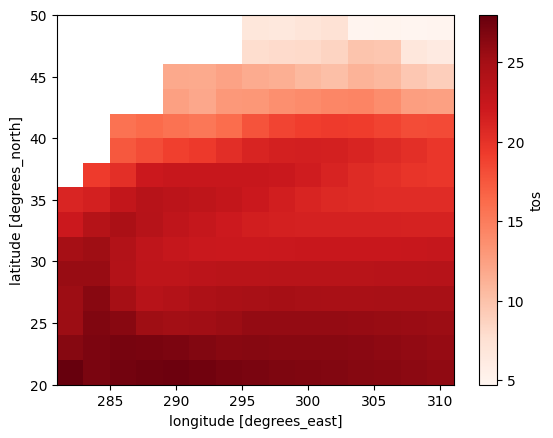

In [5]:
models['ACCESS-CM2']['tos North Atlantic seasonal mean DJF'].sel(lon=slice(282,310), lat=slice(20,50)).plot(cmap = 'Reds')

Calcolo il valore medio di SST per ogni cluster

In [6]:
n_clusters = 5 #number clusters
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3,list_cluster4]
mean_cluster = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)))# (5,len(lat),len(lon)) 
for i in range(len(list_clusters)): #ciclo su tutte le 5 liste, cioè su tutti e 5 i cluster
    sum_bias = 0
    for j in range(len(list_clusters[i])): #ciclo sui singoli modelli della lista i-esima
        model_name = list_clusters[i][j] #modello j-esimo della lista i-esima
        sum_bias = sum_bias + models[model_name]['GS box seas mean DJF']
    mean_cluster[i,:,:] = (sum_bias / len(list_clusters[i])) #media

Calcolo gradiente e determino il massimo per ogni modello, poi calcolo la media dei massimi per ogni cluster

In [7]:
n_clusters = 5 #number clusters
#Valore medio del gradiente dei modelli dei 5 cluster
mean_gradient = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lat),len(models[list_cluster0[0]]['GS box']['tos'].lon)))# (5,time,len(lat),len(lon))    
#Array con 1, 0 dove gli 1 indicano la latitudine in cui si ha il gradiente massimo medio per ogni cluster
array_max_mean = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lat),len(models[list_cluster0[0]]['GS box']['tos'].lon))) #di dimesnioni 5xtimexlatxlon
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3,list_cluster4]
for n in range(len(list_clusters)): #ciclo su tutte le 5 liste, cioè su tutti e 5 i cluster
    #gradiente sulla latitudine per ogni modello di ogni cluster
    gradient = np.zeros((len(list_clusters[n]),len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lat),len(models[list_cluster0[0]]['GS box']['tos'].lon)))
    #valore massimo per ogni gradient
    index_max_value = np.zeros((len(list_clusters[n]),len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lat),len(models[list_cluster0[0]]['GS box']['tos'].lon)))
    sum_bias = 0 #Inizializzo sum_bias per il calcolo del gradiente medio
    sum_max = 0 #Iniziallizzo sum_max per il calcolo della media del gradiente massimo
    for i in range(len(list_clusters[n])): #ciclo sui singoli modelli della lista i-esima
        for t in range(len(models[list_cluster0[0]]['GS box']['tos'].time)):
            #Ricerca del valore massimo sulla latitudine, a longitudine fissata
            for j in range(len(models[list_cluster0[0]]['GS box']['tos'].lon)): #ciclo sulle longitudini
                gradient[i,t,:,j] = np.gradient(models[list_clusters[n][i]]['GS box']['tos'][t,:,j]) #derivata lungo l'array (i,tutte le lat,lon=j), che ha valori fissati di modello scelto e longitudine --> differenza tra due latitudini vicine, a parità di longitudine
                index_max_value[i,t,:,j] = np.nanargmax(abs(gradient[i,t,:,j])) #determino l'indice del valore massimo di gradient, non considero i nan come possibili valori massimi
        sum_bias = sum_bias + gradient[i,:,:,:] #faccio la somma degli elementi dell'array gradiente a fissata longitudine e modello
        sum_max = sum_max + index_max_value[i,:,:,:]
    array_max_mean[n,:,:,:] = (sum_max / len(list_clusters[n])) #media del valore massimo del gradiente
    mean_gradient[n,:,:,:] = (sum_bias / len(list_clusters[n])) #media del gradiente

In [8]:
print(mean_gradient[0,:,:,:].shape)
print(array_max_mean[0,:,:,:].shape)
#models['ACCESS-CM2']['GS box']['tos'].shape

(396, 11, 15)
(396, 11, 15)


In [9]:
mean_gradient_xr = {}
mean_gradient_seas_mean = {}
array_max_mean_xr = {}
array_max_mean_seas = {}
for n in range(n_clusters):
    mean_gradient_xr[n] = xr.DataArray(np.empty(models['ACCESS-CM2']['GS box']['tos'].shape),dims=models['ACCESS-CM2']['GS box']['tos'].dims,coords=models['ACCESS-CM2']['GS box']['tos'].coords)
    mean_gradient_seas_mean[n] = xr.DataArray(np.empty(models['ACCESS-CM2']['GS box']['tos'][0,:,:].shape),dims=models['ACCESS-CM2']['GS box']['tos'][0,:,:].dims,coords=models['ACCESS-CM2']['GS box']['tos'][0,:,:].coords)
    array_max_mean_xr[n] = xr.DataArray(np.empty(models['ACCESS-CM2']['GS box']['tos'].shape),dims=models['ACCESS-CM2']['GS box']['tos'].dims,coords=models['ACCESS-CM2']['GS box']['tos'].coords)
    array_max_mean_seas[n] = xr.DataArray(np.empty(models['ACCESS-CM2']['GS box']['tos'][0,:,:].shape),dims=models['ACCESS-CM2']['GS box']['tos'][0,:,:].dims,coords=models['ACCESS-CM2']['GS box']['tos'][0,:,:].coords)
    mean_gradient_xr[n].data = mean_gradient[n].data
    array_max_mean_xr[n].data = array_max_mean[n].data
    mean_gradient_seas_mean[n] = compute_mean_resample_mar(mean_gradient_xr[n],"1982","2014",3)
    array_max_mean_seas[n] = compute_mean_resample_mar(array_max_mean_xr[n],"1982","2014",3)

In [10]:
#Ridefinisco array_max_mean: 1 dove sulla latitudine in cui si ha gradiente massimo medio, 0 altrimenti
for n in range(n_clusters):
    for j in range(len(array_max_mean_seas[n].lon)): #ciclo sulla longitudine
        for l in range(len(array_max_mean_seas[n].lat)): #ciclo sulle latitudini
            if l == np.round(array_max_mean_seas[n][l,j] + 0.01): #aggiungo 0.01 in modo t.c 0.5 sia arrotondato a 1
                array_max_mean_seas[n][l,j] = 1
            else:
                array_max_mean_seas[n][l,j] = 0

In [52]:
#NO --> questo è il campo seasonal mean DJF
n_clusters = 5 #number clusters
#Valore medio del gradiente dei modelli dei 5 cluster
mean_gradient = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)))# (5,len(lat),len(lon))    
#Array con 1, 0 dove gli 1 indicano la latitudine in cui si ha il gradiente massimo medio per ogni cluster
array_max_mean = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon))) #di dimesnioni 5xlatxlon
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3,list_cluster4]
for n in range(len(list_clusters)): #ciclo su tutte le 5 liste, cioè su tutti e 5 i cluster
    #gradiente sulla latitudine per ogni modello di ogni cluster
    gradient = np.zeros((len(list_clusters[n]),len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)))
    #valore massimo per ogni gradient
    index_max_value = np.zeros((len(list_clusters[n]),len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)))
    sum_bias = 0 #Inizializzo sum_bias per il calcolo del gradiente medio
    sum_max = 0 #Iniziallizzo sum_max per il calcolo della media del gradiente massimo
    for i in range(len(list_clusters[n])): #ciclo sui singoli modelli della lista i-esima
        #Ricerca del valore massimo sulla latitudine, a longitudine fissata
        for j in range(len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)): #ciclo sulle longitudini
            gradient[i,:,j] = np.gradient(models[list_clusters[n][i]]['GS box seas mean DJF'][:,j]) #derivata lungo l'array (i,tutte le lat,lon=j), che ha valori fissati di modello scelto e longitudine --> differenza tra due latitudini vicine, a parità di longitudine
            index_max_value[i,:,j] = np.nanargmax(abs(gradient[i,:,j])) #determino l'indice del valore massimo di gradient, non considero i nan come possibili valori massimi
        sum_bias = sum_bias + gradient[i,:,:] #faccio la somma degli elementi dell'array gradiente a fissata longitudine e modello
        sum_max = sum_max + index_max_value[i,:,:]
    array_max_mean[n,:,:] = (sum_max / len(list_clusters[n])) #media del valore massimo del gradiente
    mean_gradient[n,:,:] = (sum_bias / len(list_clusters[n])) #media del gradiente
    #Ridefinisco array_max_mean: 1 dove sulla latitudine in cui si ha gradiente massimo medio, 0 altrimenti
    for j in range(len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)): #ciclo sulla longitudine
        for l in range(len(models[list_cluster0[0]]['GS box seas mean DJF'].lat)): #ciclo sulle latitudini
            if l == round(array_max_mean[n,l,j] + 0.01): #aggiungo 0.01 in modo t.c 0.5 sia arrotondato a 1
                array_max_mean[n,l,j] = 1
            else:
                array_max_mean[n,l,j] = 0

Plot per ogni cluster di: media sst, media gradiente, bias medio sst con sopra punti che rappresentano la media del gradiente massimo

In [11]:
lat = models[list_cluster0[0]]['GS box seas mean DJF'].lat.values
lon = (models[list_cluster0[0]]['GS box seas mean DJF'].lon.values - 360.)
print(lon,lat)

[-78. -76. -74. -72. -70. -68. -66. -64. -62. -60. -58. -56. -54. -52.
 -50.] [29. 31. 33. 35. 37. 39. 41. 43. 45. 47. 49.]


In [12]:
#Calcolo la media del bias di SST in DJF, per ogni cluster
mean_bias = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon))) # 5xlatxlon
for n in range(n_clusters): #ciclo sui 5 cluster
    sum_bias = 0
    for i in range(len(list_clusters[n])): #ciclo sui modelli dell'n-esimo cluster
        model = models[list_clusters[n][i]]['North Atlantic bias DJF'].sel(lon=slice(282,310), lat=slice(29,50))
        sum_bias = sum_bias + model
    mean_bias[n,:,:] = sum_bias / len(list_clusters[n])

Text(0.5, 0.92, 'SST, gradiente SST, bias medio SST in DJF per ogni cluster')

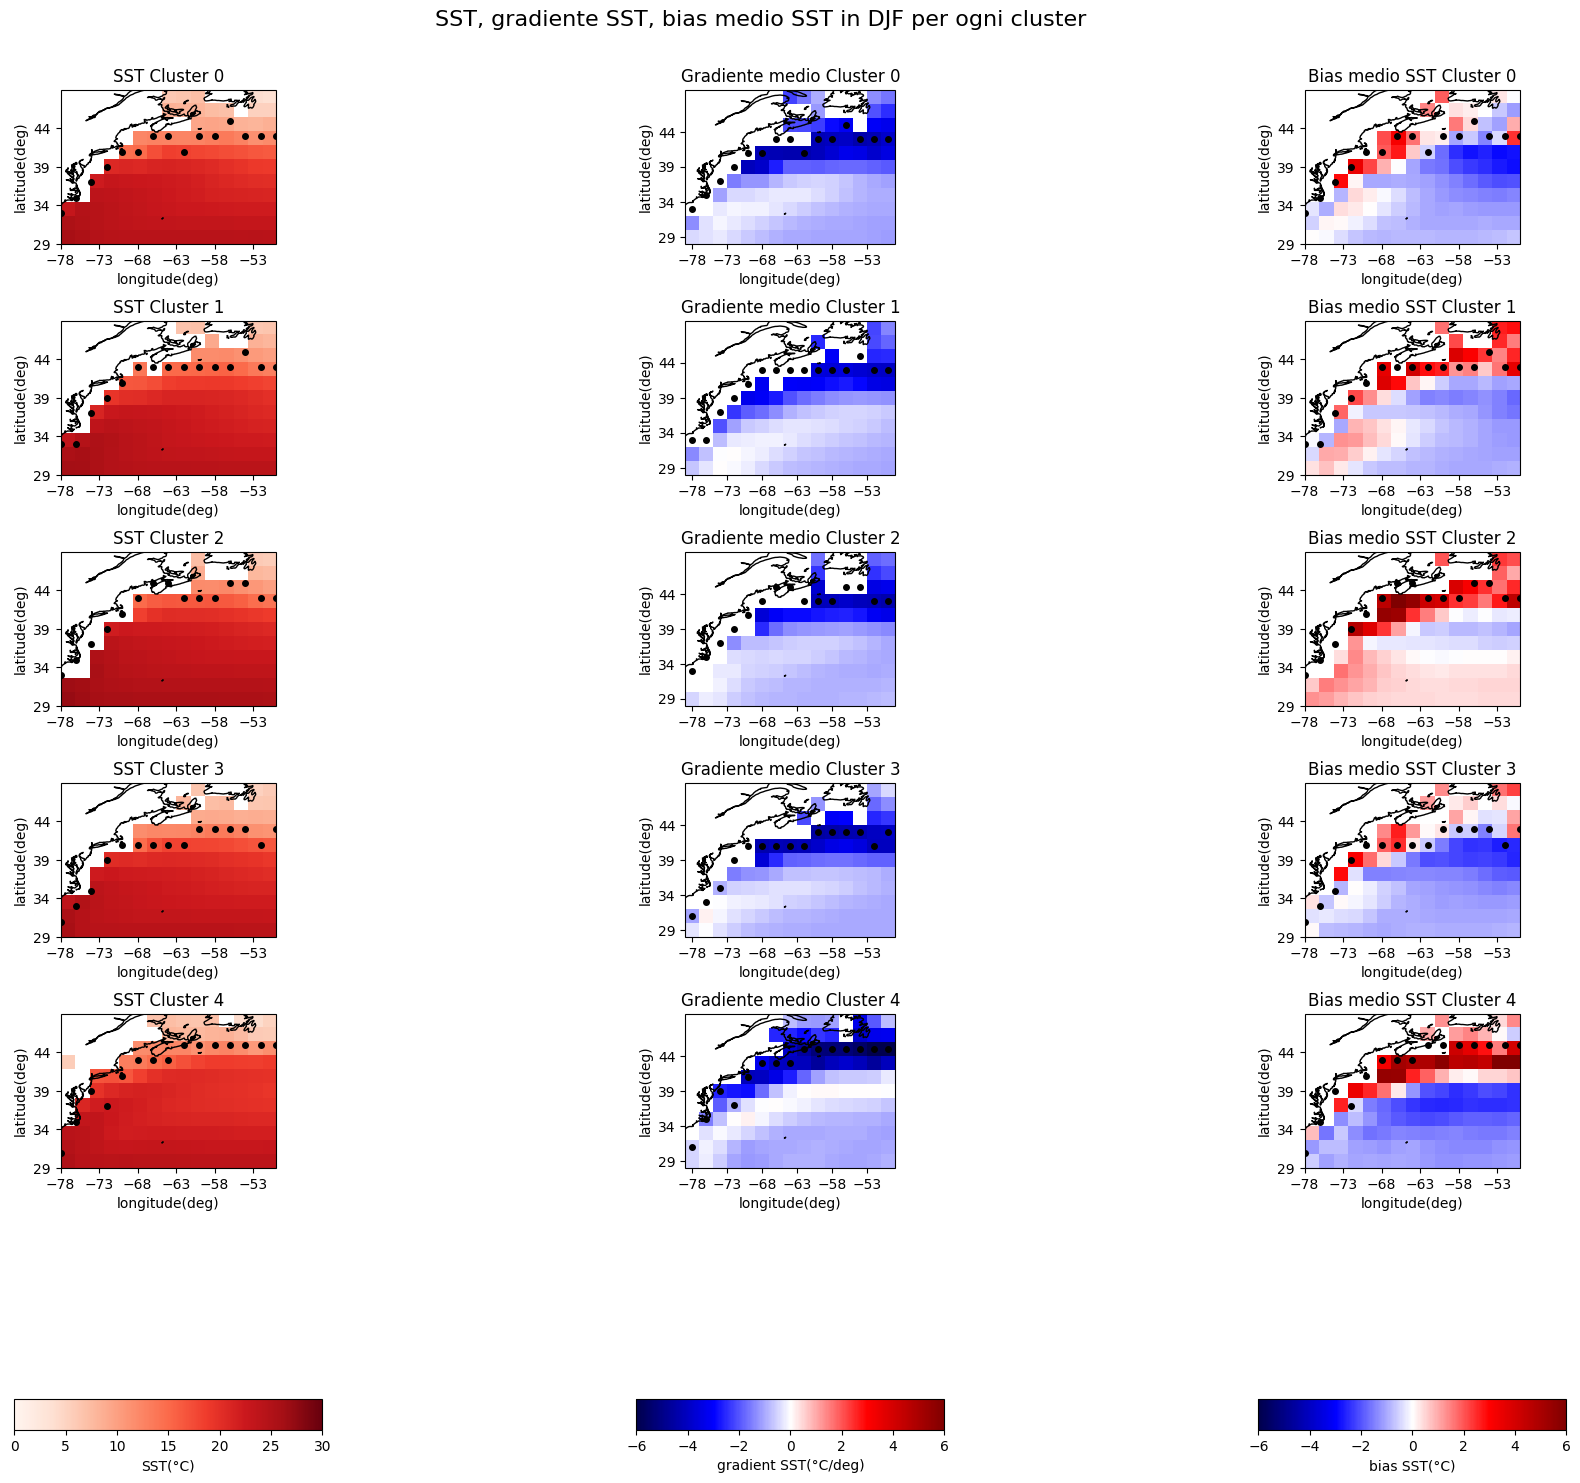

In [13]:
index = 0 #inizializzo l'indice che individua ogni cluster
fig,ax = plt.subplots(nrows=5,ncols=3,figsize=(24,20),subplot_kw={"projection": ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.5, wspace=0.01)  # Aggiungo spazi verticali e orizzontali tra le subplots
for i in range(5): #Ciclo sulle righe
    j = 0 #inziializzo indice per le colonne
    #coords = np.where(array_max_mean[index,:,:] == 1) #array di valori di longitudini e latitudini in cui array_max = 1 (cioè indica la posizione in cui c'è il max))
    coords = np.where(array_max_mean_seas[index] == 1) #array di valori di longitudini e latitudini in cui array_max = 1 (cioè indica la posizione in cui c'è il max))
    #Plot della prima colonna, cioè di SST
    # Plot dei punti solo dove array_max è uguale a 1
    punti = ax[i,j].plot(lon[coords[1]], lat[coords[0]], marker='o', color='black', markersize=4, linestyle='None')
    plot_mod_sst = ax[i,j].imshow(mean_cluster[index,::-1,:],extent=[lon.min(), lon.max(), lat.min(), lat.max()],vmin=0, vmax=30,cmap='Reds',transform=ccrs.PlateCarree())
    ax[i,j].coastlines()
    ax[i,j].set_title(f'SST Cluster {index}')
    #Plot della seconda colonna, cioè del gradiente di SST
    punti = ax[i,j+1].plot(lon[coords[1]], lat[coords[0]], marker='o', color='black', markersize=4, linestyle='None')
    #plot_mod_gradient = ax[i,j+1].imshow(mean_gradient[index,::-1,:],extent=[lon.min(), lon.max(), lat.min(), lat.max()],cmap='seismic',vmin=-6,vmax=6,transform=ccrs.PlateCarree())
    plot_mod_gradient = mean_gradient_seas_mean[index].plot(ax=ax[i,j+1],cmap='seismic',vmin=-6,vmax=6, add_colorbar=False,transform=ccrs.PlateCarree())
    #ax[i,j+1].set_extent([lon.min(), lon.max(), lat.min(),lat.max()])
    ax[i,j+1].coastlines()
    ax[i,j+1].set_title(f'Gradiente medio Cluster {index}')
    #Plot della terza colonna, cioè del bias DJF di SST
    punti = ax[i,j+2].plot(lon[coords[1]], lat[coords[0]], marker='o', color='black', markersize=4, linestyle='None')
    plot_mod_bias = ax[i,j+2].imshow(mean_bias[index,::-1,:],extent=[lon.min(), lon.max(), lat.min(), lat.max()],cmap='seismic',vmin=-6,vmax=6,transform=ccrs.PlateCarree())
    ax[i,j+2].coastlines()
    ax[i,j+2].set_title(f'Bias medio SST Cluster {index}')

    j = 0
    for j in range(3):
        ax[i,j].set_xlabel('longitude(deg)')
        ax[i,j].set_ylabel('latitude(deg)') 
        ax[i,j].set_xticks(np.arange(lon.min(), lon.max(), 5))
        ax[i,j].set_yticks(np.arange(lat.min(), lat.max(), 5))

    index = index + 1 #Aggiorno index

fig.colorbar(plot_mod_sst,ax=ax[:,0],orientation='horizontal', shrink=0.5, aspect=10).set_label('SST(°C)')
fig.colorbar(plot_mod_gradient,ax=ax[:,1],orientation='horizontal', shrink=0.5, aspect=10).set_label('gradient SST(°C/deg)')
fig.colorbar(plot_mod_bias,ax=ax[:,2],orientation='horizontal', shrink=0.5, aspect=10).set_label('bias SST(°C)')
fig.suptitle('SST, gradiente SST, bias medio SST in DJF per ogni cluster', fontsize=16, y=0.92)